# INEGIpy

INEGIpy es una librería para interactuar fácilmente con los datos del Instituto Nacinal de Geografía y Estadística (INEGI) desde Python. Su propósito es apoyar en la creación de consultas automatizadas y  en acceso a la información para el análisis de datos. 

De la información que ofrece el INEGI actualmente cuenta con un módulo dedicado al [Banco de Indicadores](https://www.inegi.org.mx/servicios/api_indicadores.html), otro dedicado al [DENUE](https://www.inegi.org.mx/servicios/api_denue.html) y otro dedicado al la información del [Marco Geoestadístico](https://www.inegi.org.mx/servicios/catalogoUnico.html).

También se encuentra en constrcción un módulo de Series dedicado a consultas automatizadas de los principales indicadores económicos como el PIB, INPC, Ocupación, etc. 

## Ejemplos de uso

In [11]:
from INEGIpy import PIB

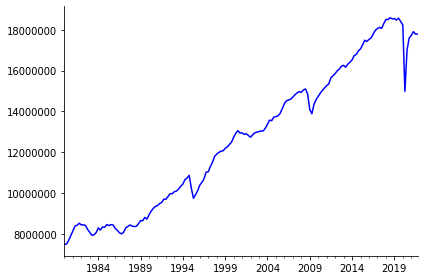

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

In [12]:
pib = PIB(token)
pib.grafica()

In [ ]:
pib.obtener_df

### Negocios en a 5km de una coordenada

In [1]:
from INEGIpy import DENUE, MarcoGeoestadistico
import pandas as pd
import geopandas as gpd
import numpy as np
from shapely.geometry import *
from geopy.geocoders import Nominatim
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
token = '92170321-528f-f1dd-5d59-f8613e072746'
denue = DENUE(token)
marco = MarcoGeoestadistico()

<AxesSubplot:>

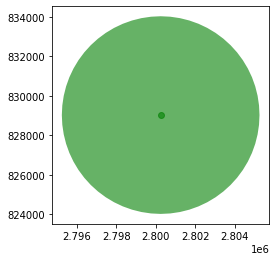

In [3]:
# construimos una capa para la zona a buscar
locator = Nominatim(user_agent='denue_app')
locator_resp = locator.geocode('Zócalo, Cuauhtémoc, Ciudad de México')
lat, lng = locator_resp.latitude, locator_resp.longitude
punto = Point(lng, lat)
zocalo = gpd.GeoDataFrame([punto], columns=['geometry'])
zocalo.crs = 'EPSG:4326' # como creamos la capa no tiene un CRS asociado
zocalo = zocalo.to_crs('EPSG:6372') # este crs nos permite realizar operaciones en metros en vez de grados en Ciudad de México
zocalo = pd.concat([zocalo, gpd.GeoDataFrame([zocalo.geometry.iloc[0].buffer(5000)], columns=['geometry'])], axis=0)
zocalo.plot(alpha=0.6, color='green')

<AxesSubplot:>

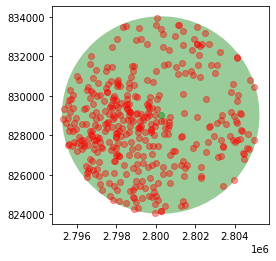

In [4]:
# utilizamos el DENUE para obtener una capa con los establecimientos en un radio de 5 km 
# inicié queriendo ver todos los establecimientos pero son demasiados para hacer buenos visuales así que acoté a solo los Oxxos
estabs = denue.Buscar('oxxo',lat,lng,5000)
estabs = estabs.to_crs('EPSG:6372') 

ax = zocalo.plot(alpha=0.4, color='green')
estabs.plot(ax=ax, alpha=0.4, color='red')

<AxesSubplot:>

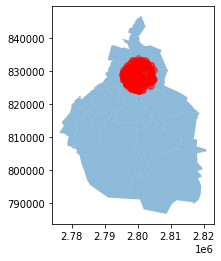

In [5]:
# utilizamos el marco geostadistico para obtener la capa del area geografica sobre la que plotear
# Si no conoces la clave de alguna entidad, municipio o localidad la puedes buscar por nombre en el marco geoestadístico

# regresa todas las manzanas en CDMX
muns = marco.Municipios(entidades='09')
muns = muns.to_crs('EPSG:6372')

ax = muns.plot(alpha = 0.5)
zocalo.plot(ax=ax, color='green', alpha=0.4)
estabs.plot(ax=ax, color='red', alpha=0.4)

<AxesSubplot:>

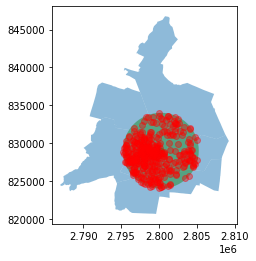

In [6]:
# reducimos a solo los municipios en el area

muns = muns[muns.geometry.intersects(zocalo.geometry.iloc[1])] # zocalo.geometry.iloc[1] es el buffer

ax = muns.plot(alpha = 0.5)
zocalo.plot(ax=ax, color='green', alpha=0.4)
estabs.plot(ax=ax, color='red', alpha=0.4)

In [7]:
# ya podemos hacer operaciones y obtener datos como las distancias al punto definido:

estabs['distancia'] = estabs.geometry.distance(zocalo.geometry.iloc[0])
estabs.head()

,CLEE,Id,Nombre,Razon_social,Clase_actividad,Estrato,Tipo_vialidad,Calle,Num_Exterior,Num_Interior,...,Correo_e,Sitio_internet,Tipo,Longitud,Latitud,CentroComercial,TipoCentroComercial,NumLocal,geometry,distancia
0,09015462112003412000008202S7,6316916,OXXO SUC 50WPJ PALMA MEX,CADENA COMERCIAL OXXO SA DE CV,Comercio al por menor en minisupers,6 a 10 personas,CALLE,PALMA,0,,...,ATENCIONCLIENTES@OXXO.COM,WWW.OXXO.COM,Fijo,-99.13525942,19.43235520,,,,POINT (2799948.266 829026.197),300.428750
1,09015462112001101000008202S8,6319281,OXXO SUC 50GBG PINO SUAREZ MEX,CADENA COMERCIAL OXXO SA DE CV,Comercio al por menor en minisupers,6 a 10 personas,AVENIDA,JOSÉ MARÍA PINO SUÁREZ,83,,...,ATENCIONCLIENTES@OXXO.COM,WWW.OXXO.COM,Fijo,-99.13241008,19.42948749,,,,POINT (2800252.890 828715.701),310.291630
2,09015462112005351000008202S5,6796478,OXXO SUC 50ICM TEMPLO MAYOR MEX,CADENA COMERCIAL OXXO SA DE CV,Comercio al por menor en minisupers,6 a 10 personas,CALLE,REPÚBLICA DE BRASIL,5,,...,ATENCIONCLIENTES@OXXO.COM,WWW.OXXO.COM,Fijo,-99.13395237,19.43505255,,,,POINT (2800079.152 829326.588),345.137576
3,09015462112005451000008202S3,6855065,OXXO SUC 50XMC REP URUGUAY II MEX,CADENA COMERCIAL OXXO SA DE CV,Comercio al por menor en minisupers,6 a 10 personas,CALLE,REPÚBLICA DE URUGUAY,131,,...,ATENCIONCLIENTES@OXXO.COM,WWW.OXXO.COM,Fijo,-99.13061102,19.42957438,,,,POINT (2800441.045 828729.057),353.769060
4,09015462112003842000008202S5,6316904,OXXO SUC 50YWD REP DEL SALVADOR MEX,CADENA COMERCIAL OXXO SA DE CV,Comercio al por menor en minisupers,6 a 10 personas,CALLE,REPÚBLICA DEL SALVADOR,96,,...,ATENCIONCLIENTES@OXXO.COM,WWW.OXXO.COM,Fijo,-99.13469909,19.42939680,,,,POINT (2800013.450 828700.903),401.254264


In [8]:
# podemos ver que la distancia mínima son 300 metros, la máxima es cercana a los 5 km y la media es de 3.1 km

estabs.distancia.min(), estabs.distancia.max(), estabs.distancia.mean()

(300.4287498970337, 4978.781953233973, 3148.330243726626)

<AxesSubplot:>

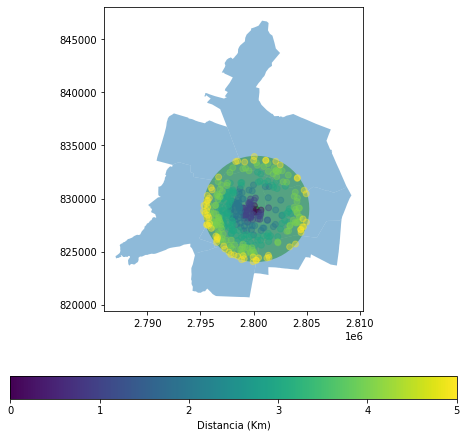

In [9]:
# podemos vizualizar la distriución espacial

estabs['dist_discreta'] = round((estabs.distancia/1000))

ax = muns.plot(alpha = 0.5, figsize=(8,8))
zocalo.plot(ax=ax, color='green', alpha=0.4)
estabs.plot(ax=ax, alpha=0.4, column='dist_discreta', legend = True, legend_kwds={'label':'Distancia (Km)','orientation':"horizontal"})

<AxesSubplot:>

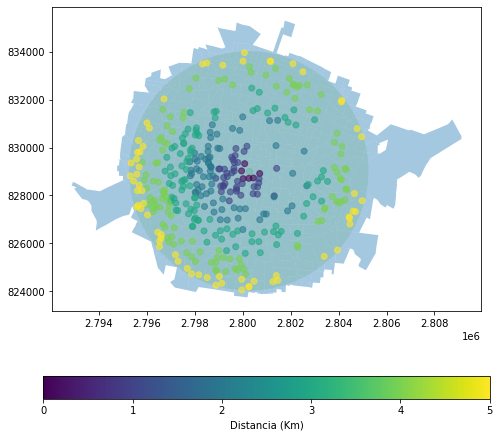

In [10]:
# podemos mejorar el mapa si usamos un nivel de agregación menor

agebs = marco.AGEBs(entidades = '09', municipios = muns.cve_agem.tolist())
agebs = agebs.to_crs('EPSG:6372')
agebs = agebs[agebs.geometry.intersects(zocalo.geometry.iloc[1])]

ax = agebs.plot(alpha = 0.4, figsize=(8,8), zorder=1)
zocalo.plot(ax=ax, color='green', alpha=0.1, zorder=2)
estabs.plot(ax=ax, alpha=0.6, column='dist_discreta',
            legend = True, legend_kwds={'label':'Distancia (Km)','orientation':"horizontal"}, zorder=3)

<AxesSubplot:>

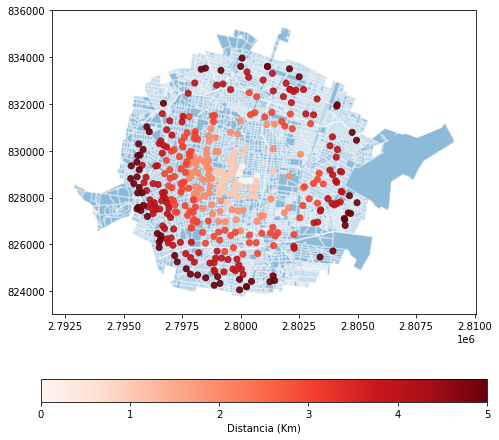

In [13]:
# para mejorar el mapa también podemos plotear las vialidades

vialidades = marco.Vialidades(entidades='09', municipios=muns.cve_agem.tolist())
vialidades = vialidades.to_crs('EPSG:6372')
agebs_dis = agebs.dissolve(by='cve_ent')
vialidades = vialidades[vialidades.geometry.intersects(agebs_dis.geometry.iloc[0])]

ax = agebs_dis.plot(alpha = 0.5, figsize=(8,8), zorder=1)
vialidades.plot(ax=ax, color='white', alpha=0.5, zorder=2)
#zocalo.plot(ax=ax, color='green', alpha=0.4, zorder=3)
estabs.plot(ax=ax, alpha=0.9, column='dist_discreta', cmap='Reds',
            legend = True, legend_kwds={'label':'Distancia (Km)','orientation':"horizontal"},zorder=4)

<AxesSubplot:>

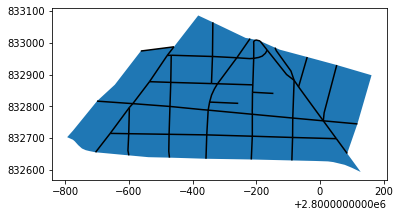

In [14]:
a = agebs.iloc[3:4]
b = vialidades[vialidades.geometry.within(a.geometry.iloc[0])]
ax = a.plot()
b.plot(ax=ax, color='black')

In [15]:
b = b.dissolve(by='cve_via')

In [16]:
c = gpd.GeoDataFrame(b.intersection(b.geometry.iloc[0]), columns=['geometry'])

<AxesSubplot:>

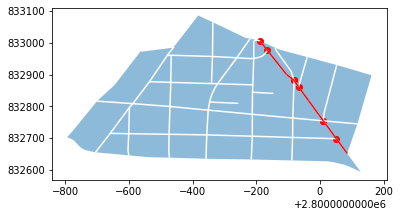

In [17]:
ax = a.plot(alpha=0.5)
b.plot(ax=ax, color='white')
c[~c.geometry.is_empty].plot(ax=ax, color='red')

In [97]:
x = gpd.GeoDataFrame(b.intersection(b.geometry.iloc[2]), columns=['geometry'])

b[b.geometry.intersects(x.geometry.iloc[0])]

,geometry,cve_agee,cve_agem,cve_loc,nomvial,tipovial,ambito,sentido
cve_via,,,,,,,,
01693,"LINESTRING (2800085.696 832651.960, 2800051.57...",09,005,0001,Paganini,Calle,Urbana,Dos sentidos
01698,"LINESTRING (2800010.597 832754.703, 2800013.13...",09,005,0001,Borodín,Calle,Urbana,Un sentido
02416,"LINESTRING (2799299.410 832816.614, 2799396.74...",09,005,0001,José A. Clave,Avenida,Urbana,Dos sentidos


In [18]:
from shapely.ops import shared_paths, split, substring, linemerge, snap

In [24]:
b.geometry = b.geometry.apply(lambda x: linemerge(x) if isinstance(x, MultiLineString) else x)

<AxesSubplot:>

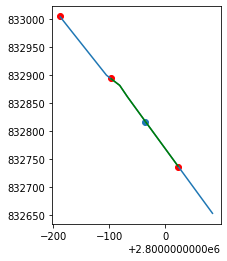

In [61]:
d = b.geometry.iloc[0]
o = Point(list(d.coords)[6])
l1, l2 = list(split(d, o).geoms)
p1, p2 = l1.interpolate(-100), l2.interpolate(100)
ax=gpd.GeoDataFrame([o, l1, l2], columns=['geometry']).plot()
gpd.GeoDataFrame([p1, p2, Point(l2.coords[-1])], columns=['geometry']).plot(ax=ax, color='red')
gpd.GeoDataFrame([cortar(l1, l1.length - 100)[1], cortar(l2, 100)[0]], columns=['geometry']).plot(ax=ax, color='green')

In [157]:
c = vialidades.intersection(d)
c[~c.geometry.is_empty]

656                         POINT (2800010.597 832754.703)
4628                        POINT (2799918.851 832881.994)
4629                        POINT (2799834.283 832976.859)
5714     MULTILINESTRING ((2800010.597 832754.703, 2799...
6155     LINESTRING (2800085.696 832651.960, 2800051.57...
6182     LINESTRING (2799932.796 832861.402, 2799918.85...
8634                        POINT (2800010.597 832754.703)
8643                        POINT (2800010.597 832754.703)
8644     MULTILINESTRING ((2800051.571 832698.645, 2800...
9352                        POINT (2799932.796 832861.402)
11219                       POINT (2800085.696 832651.960)
11825    LINESTRING (2799811.509 833005.741, 2799834.28...
12139                       POINT (2799918.851 832881.994)
14712                       POINT (2800051.571 832698.645)
17036    MULTILINESTRING ((2799834.283 832976.859, 2799...
19498                       POINT (2800085.696 832651.960)
20377                       POINT (2799811.509 833005.74

In [172]:
def cortar(via, distancia): 
    # corta una linea en una distancia definida
    # función obtenida de la documentación de Shapely
    if distancia <= 0.0 or distancia >= via.length:
        return [LineString(via)]
    coords = list(via.coords)
    for i, p in enumerate(coords):
        pd = via.project(Point(p))
        if pd == distancia:
            return [
                LineString(coords[:i+1]),
                LineString(coords[i:])]
        if pd > distancia:
            cp = via.interpolate(distancia)
            return [
                LineString(coords[:i] + [(cp.x, cp.y)]),
                LineString([(cp.x, cp.y)] + coords[i:])]
        
def obtener_poligono(p_inicial, vias, distancia, geodf, pol_coords = list(), vias_checadas = list(), puntos_checados = list()):
    if distancia <= 0.5 or p_inicial in puntos_checados:
        return pol_coords, vias_checadas
    puntos_checados.append(p_inicial)
    for via in vias:
        if via in vias_checadas: continue
        vias_checadas.append(via)
        # partimos la vialidad en dos a partir del punto de inicio y en la distancia hacia ambos lados
        via_cortada = list(split(via, p_inicial).geoms)
        if len(via_cortada) == 1: via_1, via_2 = via_cortada[0], LineString([p_inicial, p_inicial])
        else: via_1, via_2 = via_cortada
        via_1 = cortar(via_1, via_1.length - distancia)
        if len(via_1) == 1: 
            via_1 = via_1[0]
        else: via_1 = via_1[1]
        via_2 = cortar(via_2, distancia)[0]
        if via_1.length >= distancia: 
            pol_coords.append(via_1.coords[0])
        if via_2.length >= distancia: 
            pol_coords.append(via_2.coords[-1])
        # obtenemos las intersecciones en los tramos
        intersecciones_1 = gpd.GeoDataFrame(geodf.intersection(via_1), columns=['geometry'])
        intersecciones_2 = gpd.GeoDataFrame(geodf.intersection(via_2), columns=['geometry'])
        intersecciones_1.geometry = intersecciones_1.geometry.apply(lambda i: i if isinstance(i, Point) else np.nan)
        intersecciones_2.geometry = intersecciones_2.geometry.apply(lambda i: i if isinstance(i, Point) else np.nan)
        intersecciones_1 = intersecciones_1[~intersecciones_1.geometry.isna()]
        intersecciones_2 = intersecciones_2[~intersecciones_2.geometry.isna()]
        intersecciones_1['distancia'] = intersecciones_1.geometry.apply(lambda i: via_1.length - via_1.project(i))
        intersecciones_2['distancia'] = intersecciones_2.geometry.apply(lambda i: via_2.project(i))
        #print('intersecciones 1')
        #display(intersecciones_1)
        #print('intersecciones 2')
        
        #display(intersecciones_2)
        intersecciones = pd.concat([intersecciones_1, intersecciones_2], axis=0)
        intersecciones = intersecciones.drop_duplicates(subset=['geometry'])
        intersecciones = intersecciones[intersecciones.distancia != 0]
        display(intersecciones)
        # ahora volvemos a llamar la función  para los siguientes puntos
        if intersecciones.shape[0] > 0:
            for i, interseccion in enumerate(intersecciones.geometry):
                n_vias = geodf[geodf.geometry.intersects(interseccion)].drop_duplicates(subset='cve_via')
                display(n_vias)
                return obtener_poligono(interseccion, geodf[geodf.geometry.intersects(interseccion)].geometry,
                                        distancia - intersecciones.distancia.iloc[i], geodf, pol_coords, vias_checadas)
        else: 
            return pol_coords, vias_checadas
        
       

In [173]:
test = obtener_poligono(o, [d], 2000, vialidades)

,geometry,distancia
656,POINT (2800010.597 832754.703),77.606221
11219,POINT (2800085.696 832651.960),204.869497
14712,POINT (2800051.571 832698.645),147.042239
4628,POINT (2799918.851 832881.994),79.315100
4629,POINT (2799834.283 832976.859),207.083440
9352,POINT (2799932.796 832861.402),54.445807
20377,POINT (2799811.509 833005.741),243.864516


,geometry,cve_agee,cve_agem,cve_loc,cve_via,nomvial,tipovial,ambito,sentido
656,"LINESTRING (2800010.597 832754.703, 2800013.13...",09,005,0001,01698,Borodín,Calle,Urbana,Un sentido
5714,"LINESTRING (2800010.597 832754.703, 2799995.34...",09,005,0001,01693,Paganini,Calle,Urbana,Dos sentidos
8634,"LINESTRING (2799914.559 832763.476, 2800010.59...",09,005,0001,02416,José A. Clave,Avenida,Urbana,Dos sentidos


,geometry,distancia
5714,POINT (2800010.597 832754.703),180.661923


,geometry,cve_agee,cve_agem,cve_loc,cve_via,nomvial,tipovial,ambito,sentido
656,"LINESTRING (2800010.597 832754.703, 2800013.13...",09,005,0001,01698,Borodín,Calle,Urbana,Un sentido
5714,"LINESTRING (2800010.597 832754.703, 2799995.34...",09,005,0001,01693,Paganini,Calle,Urbana,Dos sentidos
8634,"LINESTRING (2799914.559 832763.476, 2800010.59...",09,005,0001,02416,José A. Clave,Avenida,Urbana,Dos sentidos


In [174]:
test

([],
  <shapely.geometry.linestring.LineString at 0x1f1f06b2ca0>])